In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
from twitter.twitter_collection import TwitterCollection
from twitter.tweet_sentiment_analyzer import TweetSentimentAnalyzer
from data_pipelines.data_manipulation import DataManipulation
from logger.logger import Logger

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = 'ignore', category = pd.errors.PerformanceWarning)
%matplotlib inline

Python-dotenv could not parse statement starting at line 11
[nltk_data] Downloading package stopwords to /home/kozan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Using state Antalya server backend.


In [2]:
SYMBOL = 'BTC-USD'
SYMBOL_NAME = 'Bitcoin'
SYMBOL_CUT = 'btc'
scale = 1
range_list = [i for i in range(5,21)]
range_list = [i*scale for i in range_list]
interval = '1h'
start_date = '2020-06-30'
end_date = '2022-07-01'
source = 'yahoo'
LOG_PATH = '../logger' + os.sep + "logs"
LOG_FILE_NAME_PREFIX = f"log_{SYMBOL_CUT}_{start_date}_{end_date}"

logger = Logger(LOG_PATH, LOG_FILE_NAME_PREFIX)
tsa = TweetSentimentAnalyzer()
data = DataManipulation(SYMBOL, source, range_list, start_date=start_date, 
                        end_date=end_date, interval=interval, scale=scale, 
                        prefix_path='..', saved_to_csv=True,
                        logger=logger)
df_price = data.df.copy()

1 ) 15-12-2022 14_31_06 MainThread INFO\ Initialized logging at path ../logger/logs/log_btc_2020-06-30_2022-07-01_15-12-2022_14_31_06.log
2 ) 15-12-2022 14_31_07 MainThread DEBUG\ Get data from local file ../data/outputs/data_ind/BTC-USD/BTC-USD_df_2020-06-30_2022-07-01_1h.csv


In [3]:
df_price_ext = data.extract_features()
close_col = df_price.loc['2021-01-01':'2022-06-27',['close','volume']].copy()

In [4]:
sent_tweets = pd.read_csv('btc_archieve/btc_hourly_sent_score.csv')
sent_tweets.Date = pd.to_datetime(sent_tweets.Date)
sent_tweets.set_index('Date', inplace=True, drop=True)

In [5]:
if interval == '1h':
    sent_tweets.index = sent_tweets.index.tz_convert(None)

In [6]:
df_final = tsa.concat_ohlc_compound_score(df_price_ext, sent_tweets)
df_final = df_final.loc['2021-01-01':,:].copy()
df_final.dropna(inplace=True)

In [7]:
sent_tweets.head()

,compound_total
Date,
2021-01-01 00:00:00,0.2208
2021-01-01 01:00:00,0.1708
2021-01-01 02:00:00,0.1684
2021-01-01 03:00:00,0.1578
2021-01-01 04:00:00,0.2447


In [7]:
data.normalized_df(df_final, 'compound_total')
data.normalized_df(df_final, 'kz_score')
df_final.tail()

,st_stoch,st_ich,st_cut_ema5_sma10,st_macd,st_ich_close,st_dmi,st_cut_sma10_close,st_hisse,st_mfi,st_fishert,...,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,feature_label,kz_score,compound_total
2022-06-30 18:00:00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,2.0000,2.0000,...,0.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.2261,0.2000
2022-06-30 19:00:00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,2.0000,2.0000,...,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2131,0.1924
2022-06-30 20:00:00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,2.0000,2.0000,...,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.1953,0.1725
2022-06-30 21:00:00,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,2.0000,2.0000,...,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.1952,0.2130
2022-06-30 22:00:00,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,2.0000,2.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.2834,0.2045


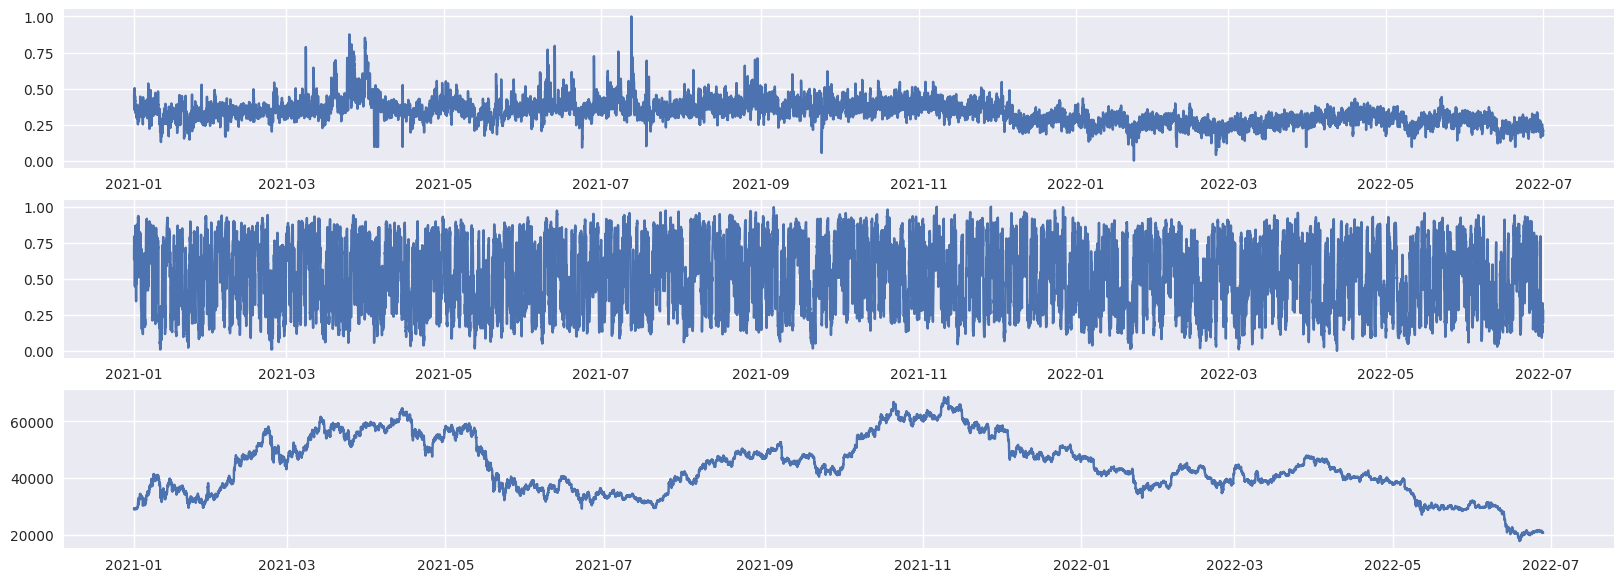

In [8]:
fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(20,7))
ax1.plot(df_final.compound_total)
ax2.plot(df_final.index, df_final.kz_score)
ax3.plot(close_col.index, close_col.close)

In [9]:
df = df_final.copy()
df.reset_index(drop=True, inplace=True)
df.head()

,st_stoch,st_ich,st_cut_ema5_sma10,st_macd,st_ich_close,st_dmi,st_cut_sma10_close,st_hisse,st_mfi,st_fishert,...,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,feature_label,kz_score,compound_total
0,1.0000,1.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,2.0000,2.0000,...,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.6357,0.4570
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,2.0000,2.0000,...,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.7930,0.3751
2,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,2.0000,2.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000,0.7600,0.3711
3,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,2.0000,2.0000,...,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000,0.0000,0.7821,0.3537
4,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,2.0000,2.0000,...,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.7595,0.4961


In [14]:
y = df.feature_label
X = df.drop(columns=['feature_label'], axis=1)

In [11]:
X

,st_stoch,st_ich,st_cut_ema5_sma10,st_macd,st_ich_close,st_dmi,st_cut_sma10_close,st_hisse,st_mfi,st_fishert,...,log_return,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,kz_score,compound_total
0,1.0000,1.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,2.0000,2.0000,...,0.0025,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.6357,0.4570
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,2.0000,2.0000,...,0.0142,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.7930,0.3751
2,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,2.0000,2.0000,...,-0.0073,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.7600,0.3711
3,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,2.0000,2.0000,...,0.0029,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000,0.7821,0.3537
4,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,2.0000,2.0000,...,-0.0020,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000,0.0000,0.7595,0.4961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13085,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,2.0000,2.0000,...,-0.0069,0.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.2261,0.2000
13086,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,2.0000,2.0000,...,-0.0025,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.2131,0.1924
13087,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,2.0000,2.0000,...,-0.0091,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1953,0.1725
13088,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,2.0000,2.0000,...,0.0034,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1952,0.2130


In [15]:
from sklearn import preprocessing
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=False)
#X_train.tail(), X_test.head()
#poly = preprocessing.PolynomialFeatures(2)
#X_p = poly.fit_transform(X)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.model_selection import StratifiedKFold
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot

model = XGBClassifier(tree_method='gpu_hist')
n_estimators = [50, 100, 150, 200, 500, 1000]
max_depth = [1, 2, 3, 4, 6, 8, 12, 16]
eta = [0.1, 0.3, 0.01]

param_grid = dict(max_depth=max_depth, n_estimators=n_estimators, eta=eta)
#kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=tscv,
verbose=1)
grid_result = grid_search.fit(X, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# plot results
import numpy
scores = numpy.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
    pyplot.plot(n_estimators, scores[i], label='depth: ' + str(value))

[0]	validation_0-logloss:0.69221	validation_1-logloss:0.69302
[1]	validation_0-logloss:0.69175	validation_1-logloss:0.69317
[2]	validation_0-logloss:0.69138	validation_1-logloss:0.69355
[3]	validation_0-logloss:0.69032	validation_1-logloss:0.69362
[4]	validation_0-logloss:0.68966	validation_1-logloss:0.69388
[5]	validation_0-logloss:0.68919	validation_1-logloss:0.69386
[6]	validation_0-logloss:0.68902	validation_1-logloss:0.69346
[7]	validation_0-logloss:0.68886	validation_1-logloss:0.69352
[8]	validation_0-logloss:0.68854	validation_1-logloss:0.69392
[9]	validation_0-logloss:0.68802	validation_1-logloss:0.69395
[10]	validation_0-logloss:0.68774	validation_1-logloss:0.69436
[11]	validation_0-logloss:0.68766	validation_1-logloss:0.69432
[12]	validation_0-logloss:0.68742	validation_1-logloss:0.69481
[13]	validation_0-logloss:0.68725	validation_1-logloss:0.69505
[14]	validation_0-logloss:0.68712	validation_1-logloss:0.69470
[15]	validation_0-logloss:0.68668	validation_1-logloss:0.69336
[1

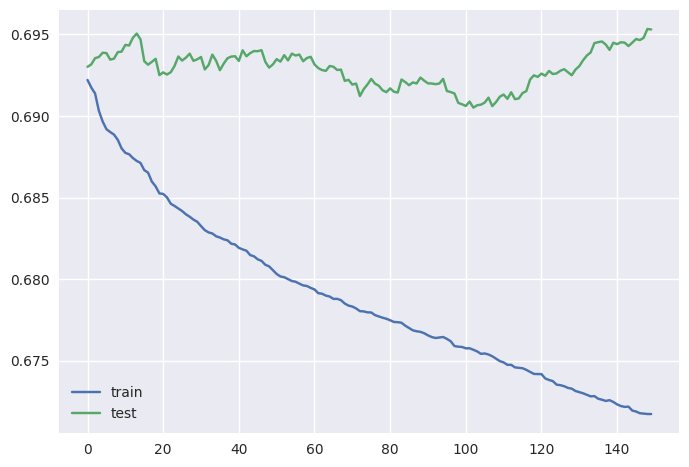

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier
from matplotlib import pyplot

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=False)
model = XGBClassifier(n_estimators=150, tree_method='gpu_hist', eta=0.3, 
                    subsample=0.5, colsample_bytree=0.5, max_depth=1)
evalset = [(X_train, y_train), (X_test,y_test)]

model.fit(X_train, y_train, eval_metric='logloss', eval_set=evalset)
# evaluate performance
model.save_model('model_file_name.json')
yhat = model.predict(X_test)
score = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % score)
# retrieve performance metrics
results = model.evals_result()
# plot learning curves
pyplot.plot(results['validation_0']['logloss'], label='train')
pyplot.plot(results['validation_1']['logloss'], label='test')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [13]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.model_selection import StratifiedKFold
import matplotlib
matplotlib.use('Agg')

model = XGBClassifier(tree_method='gpu_hist')
n_estimators = range(50, 500, 50)
param_grid = dict(n_estimators=n_estimators)
#kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=tscv)
grid_result = grid_search.fit(X, y)


print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -1.091104 using {'n_estimators': 50}
-1.091104 (0.143846) with: {'n_estimators': 50}
nan (nan) with: {'n_estimators': 100}
nan (nan) with: {'n_estimators': 150}
-1.288511 (0.113209) with: {'n_estimators': 200}
-1.315795 (0.109588) with: {'n_estimators': 250}
-1.333459 (0.101806) with: {'n_estimators': 300}
-1.345655 (0.094513) with: {'n_estimators': 350}
-1.356326 (0.091073) with: {'n_estimators': 400}
-1.363520 (0.089509) with: {'n_estimators': 450}


In [14]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.model_selection import StratifiedKFold
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot

# grid search
model = XGBClassifier(tree_method='gpu_hist')
max_depth = range(1, 16, 2)
print(max_depth)
param_grid = dict(max_depth=max_depth)
#kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=tscv,
verbose=1)
grid_result = grid_search.fit(X, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

range(1, 16, 2)
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best: -0.836149 using {'max_depth': 1}
-0.836149 (0.193948) with: {'max_depth': 1}
-1.121057 (0.231591) with: {'max_depth': 3}
-1.174630 (0.190588) with: {'max_depth': 5}
-1.199151 (0.131841) with: {'max_depth': 7}
-1.167467 (0.146885) with: {'max_depth': 9}
-1.175093 (0.132829) with: {'max_depth': 11}
-1.200006 (0.136686) with: {'max_depth': 13}
-1.164934 (0.128478) with: {'max_depth': 15}


In [15]:
model = XGBClassifier(tree_method='gpu_hist')
n_estimators = [50, 100, 150, 200, 500, 1000]
max_depth = [1, 2, 3, 4, 6, 8, 12, 16]
eta = [0.1, 0.3, 0.01]

param_grid = dict(max_depth=max_depth, n_estimators=n_estimators, eta=eta)
#kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=tscv,
verbose=1)
grid_result = grid_search.fit(X, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# plot results
import numpy
scores = numpy.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
    pyplot.plot(n_estimators, scores[i], label='depth: ' + str(value))

Fitting 5 folds for each of 126 candidates, totalling 630 fits
Best: -0.696429 using {'eta': 0.01, 'max_depth': 1, 'n_estimators': 50}
-0.716149 (0.033809) with: {'eta': 0.1, 'max_depth': 1, 'n_estimators': 50}
-0.738244 (0.063717) with: {'eta': 0.1, 'max_depth': 1, 'n_estimators': 100}
-0.763856 (0.095356) with: {'eta': 0.1, 'max_depth': 1, 'n_estimators': 150}
-0.781671 (0.122759) with: {'eta': 0.1, 'max_depth': 1, 'n_estimators': 200}
-0.870350 (0.218084) with: {'eta': 0.1, 'max_depth': 1, 'n_estimators': 500}
-0.983633 (0.336056) with: {'eta': 0.1, 'max_depth': 1, 'n_estimators': 1000}
-0.762317 (0.059965) with: {'eta': 0.1, 'max_depth': 2, 'n_estimators': 50}
-0.827526 (0.115991) with: {'eta': 0.1, 'max_depth': 2, 'n_estimators': 100}
-0.887049 (0.163458) with: {'eta': 0.1, 'max_depth': 2, 'n_estimators': 150}
-0.932060 (0.186293) with: {'eta': 0.1, 'max_depth': 2, 'n_estimators': 200}
-1.123401 (0.245211) with: {'eta': 0.1, 'max_depth': 2, 'n_estimators': 500}
-1.312434 (0.253412

ValueError: cannot reshape array of size 126 into shape (7,6)